In [2]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [4]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [6]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


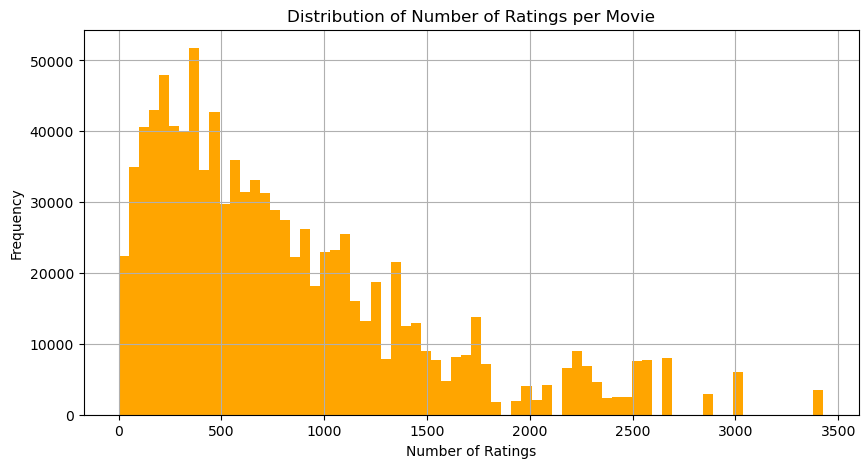

In [7]:
# Merging ratings with movies to add movie titles
m_ratings = pd.merge(ratings, movies, on='movie_id')

# Calculate the number of ratings for each movie
m_ratings['n_ratings'] = m_ratings.groupby('title')['title'].transform('count')

# Plot histogram of the number of ratings
plt.figure(figsize=(10,5))
m_ratings['n_ratings'].hist(bins=70, color='orange')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings per Movie')
plt.grid(True)
plt.show()

Top 10 Movies by Number of Ratings:
                                                    title  n_ratings  \
107009                             American Beauty (1999)       3428   
46757           Star Wars: Episode IV - A New Hope (1977)       2991   
128353  Star Wars: Episode V - The Empire Strikes Back...       2990   
70730   Star Wars: Episode VI - Return of the Jedi (1983)       2883   
116538                               Jurassic Park (1993)       2672   
52255                          Saving Private Ryan (1998)       2653   
102056                  Terminator 2: Judgment Day (1991)       2649   
140405                                 Matrix, The (1999)       2590   
23270                           Back to the Future (1985)       2583   
135921                   Silence of the Lambs, The (1991)       2578   

        avg_rating  
107009    4.317386  
46757     4.453694  
128353    4.292977  
70730     4.022893  
116538    3.763847  
52255     4.337354  
102056    4.058513  
140

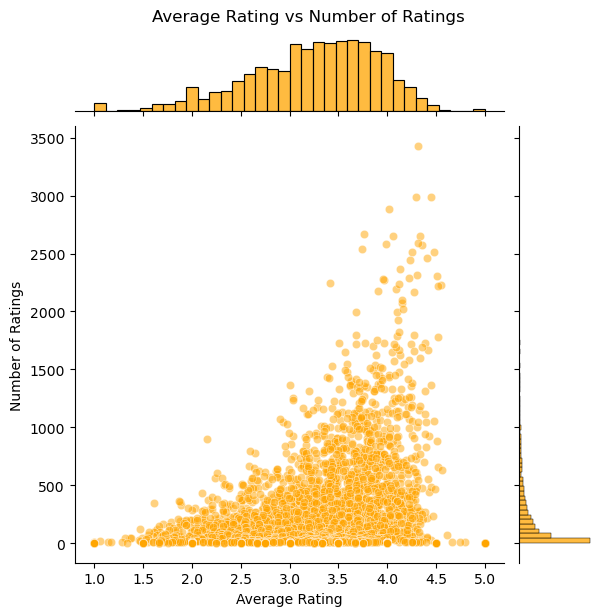

In [8]:
# Calculate the average rating for each movie
m_ratings['avg_rating'] = m_ratings.groupby('title')['rating'].transform('mean')

# Display top 10 movies by number of ratings
top_rated_movies = m_ratings[['title', 'n_ratings', 'avg_rating']].drop_duplicates().sort_values(by='n_ratings', ascending=False).head(10)
print("Top 10 Movies by Number of Ratings:")
print(top_rated_movies)

# Display top 10 movies by average rating (with at least 50 ratings)
popular_movies = m_ratings[m_ratings['n_ratings'] >= 50]
top_avg_rated_movies = popular_movies[['title', 'n_ratings', 'avg_rating']].drop_duplicates().sort_values(by='avg_rating', ascending=False).head(10)
print("\nTop 10 Movies by Average Rating (with at least 50 ratings):")
print(top_avg_rated_movies)

# Create a new dataframe for the jointplot
ratings_summary = m_ratings[['title', 'n_ratings', 'avg_rating']].drop_duplicates()

# Rename columns for clarity in the plot
ratings_summary.rename(columns={'n_ratings': 'number_ratings', 'avg_rating': 'rating'}, inplace=True)

# Plot jointplot of average rating vs number of ratings
sns.jointplot(x='rating', y='number_ratings', data=ratings_summary, alpha=0.5, color='orange')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.suptitle('Average Rating vs Number of Ratings', y=1.02)
plt.show()

In [27]:
# Calculate the number of unique users and unique movies in the ratings dataset
n_users = ratings['user_id'].nunique()  # Using nunique() for efficiency and clarity
n_movies = ratings['movie_id'].nunique()

# Print the results with formatted string for better readability
print(f'Number of users = {n_users} | Number of movies = {n_movies}')

Number of users = 6040 | Number of movies = 3706


In [28]:
# Pivot the ratings dataframe to create a user-movie matrix
# Fill missing values with 0
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Display the first few rows of the resulting matrix
ratings_matrix.head()


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Convert the ratings matrix to a NumPy array for efficient numerical operations
R = ratings_matrix.values  # Alternatively, ratings_matrix.to_numpy()

# Calculate the mean rating for each user
user_ratings_mean = np.mean(R, axis=1)

# Demean the ratings matrix by subtracting the mean rating for each user
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Calculate the sparsity level of the dataset
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)

# Print the sparsity level as a percentage
print(f'The sparsity level of MovieLens1M dataset is {sparsity * 100}%')


The sparsity level of MovieLens1M dataset is 95.5%


In [30]:
# Perform Singular Value Decomposition (SVD) on the demeaned ratings matrix
U, sigma, Vt = svds(Ratings_demeaned, k=50)

# Convert sigma to a diagonal matrix for matrix multiplication
sigma_diag = np.diag(sigma)

# Predict all user ratings by reconstructing the ratings matrix
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt) + user_ratings_mean.reshape(-1, 1)

# Convert the predicted ratings matrix to a DataFrame with appropriate column names
preds = pd.DataFrame(all_user_predicted_ratings, columns=ratings_matrix.columns)

# Display the first few rows of the predicted ratings DataFrame
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [31]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    # Get the index of the user's predictions
    user_row_number = userID - 1  # Adjusting for 0-indexing
    
    # Get and sort the user's predictions
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge with the movie information
    user_data = original_ratings[original_ratings.user_id == userID]
    user_full = user_data.merge(movies, how='left', on='movie_id').sort_values(['rating'], ascending=False)

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending the highest {num_recommendations} predicted rating movies not already rated.')

    # Recommend the highest predicted rating movies that the user hasn't seen yet
    recommendations = (
        movies[~movies['movie_id'].isin(user_full['movie_id'])]  # Movies not rated by user
        .merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left', on='movie_id')
        .rename(columns={user_row_number: 'Predictions'})
        .sort_values('Predictions', ascending=False)
        .iloc[:num_recommendations, :-1]  # Select the top N recommendations
    )

    return user_full, recommendations

In [34]:
already_rated, predictions = recommend_movies(preds, 985, movies, ratings, 10)
already_rated.head(10)

User 985 has already rated 146 movies.
Recommending the highest 10 predicted rating movies not already rated.


,user_id,movie_id,rating,timestamp,title,genres
122,985,1036,5,975097890,Die Hard (1988),Action|Thriller
92,985,3168,5,975098470,Easy Rider (1969),Adventure|Drama
124,985,2924,5,975098043,Drunken Master (Zui quan) (1979),Action|Comedy
59,985,1130,5,975099340,"Howling, The (1980)",Horror
121,985,2918,5,975099035,Ferris Bueller's Day Off (1986),Comedy
120,985,1032,5,975098701,Alice in Wonderland (1951),Animation|Children's|Musical
89,985,3147,5,975098323,"Green Mile, The (1999)",Drama|Thriller
34,985,1805,5,975099497,Wild Things (1998),Crime|Drama|Mystery|Thriller
116,985,2762,5,975098188,"Sixth Sense, The (1999)",Thriller
115,985,3706,5,975099153,Angel Heart (1987),Film-Noir|Mystery|Thriller


In [35]:
predictions

,movie_id,title,genres
2512,2692,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance
4,6,Heat (1995),Action|Crime|Thriller
3371,3578,Gladiator (2000),Action|Drama
3320,3527,Predator (1987),Action|Sci-Fi|Thriller
2219,2391,"Simple Plan, A (1998)",Crime|Thriller
566,588,Aladdin (1992),Animation|Children's|Comedy|Musical
2366,2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller
1273,1358,Sling Blade (1996),Drama|Thriller
30,32,Twelve Monkeys (1995),Drama|Sci-Fi
1839,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama


In [37]:
# Load the Reader class to define the format of the ratings data
reader = Reader()

# Load the ratings dataset using the Dataset class
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Initialize lists to store results
factors = []       # List to store number of factors
min_rmse = []      # List to store minimum RMSE
max_rmse = []      # List to store maximum RMSE
avg_rmse = []      # List to store average RMSE
min_mae = []       # List to store minimum MAE
avg_mae = []       # List to store average MAE
max_mae = []       # List to store maximum MAE


In [38]:
# Loop over different numbers of factors
for num_factors in range(20, 201, 20):
    # Initialize the SVD algorithm with the current number of factors and without bias
    svd = SVD(biased=False, n_factors=num_factors)
    
    # Evaluate the algorithm using cross-validation
    results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
    
    # Append the results to the corresponding lists
    factors.append(num_factors)
    min_rmse.append(results['test_rmse'].min())
    avg_rmse.append(results['test_rmse'].mean())
    max_rmse.append(results['test_rmse'].max())
    min_mae.append(results['test_mae'].min())
    avg_mae.append(results['test_mae'].mean())
    max_mae.append(results['test_mae'].max())

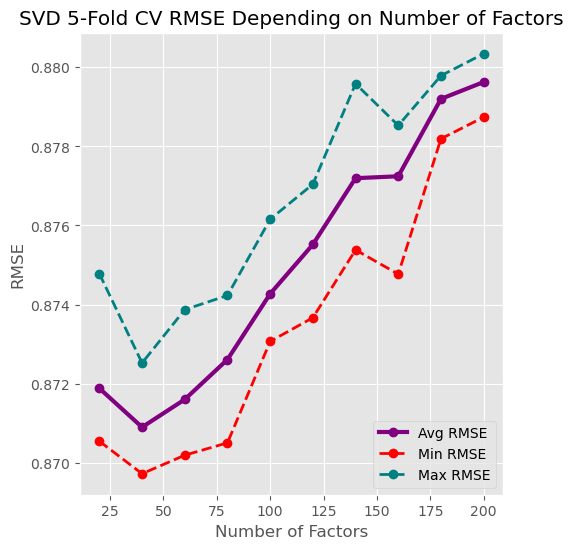

In [39]:
# Plot RMSE results
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(factors, avg_rmse, marker='o', linewidth=3, color='purple', label='Avg RMSE')  # Purple for Avg RMSE
plt.plot(factors, min_rmse, marker='o', linewidth=2, linestyle='--', color='red', label='Min RMSE')  # Red for Min RMSE
plt.plot(factors, max_rmse, marker='o', linewidth=2, linestyle='--', color='teal', label='Max RMSE')  # Teal for Max RMSE
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.grid(visible=True)
plt.title("SVD 5-Fold CV RMSE Depending on Number of Factors")
plt.legend(loc='lower right')


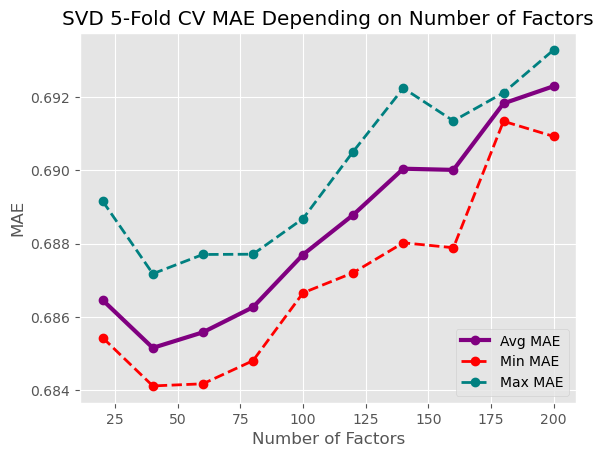

In [43]:
# Plot MAE results

plt.plot(factors, avg_mae, marker='o', linewidth=3, color='purple', label='Avg MAE')  # Purple for Avg MAE
plt.plot(factors, min_mae, marker='o', linewidth=2, linestyle='--', color='red', label='Min MAE')  # Red for Min MAE
plt.plot(factors, max_mae, marker='o', linewidth=2, linestyle='--', color='teal', label='Max MAE')  # Teal for Max MAE
plt.xlabel('Number of Factors')
plt.ylabel('MAE')
plt.grid(visible=True)
plt.title("SVD 5-Fold CV MAE Depending on Number of Factors")
plt.legend(loc='lower right')

plt.show()

In [41]:
# Select the best number of factors 
best_factors = 40

# Initialize the SVD algorithm with the selected number of factors
svd = SVD(biased=False, n_factors=best_factors)

# Evaluate the selected model using cross-validation
best_model_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
print(best_model_results)

# Retrain the model on the full dataset using the best number of factors
svd = SVD(biased=False, n_factors=best_factors)

# Build the full training set
trainset = data.build_full_trainset()

# Train the algorithm on the full training set
svd.fit(trainset)

{'test_rmse': array([0.87217135, 0.87190814, 0.87196272, 0.86839766, 0.86844516]), 'test_mae': array([0.68543207, 0.6859887 , 0.68544677, 0.68361544, 0.68306186]), 'fit_time': (5.702872276306152, 6.510591506958008, 6.7967140674591064, 6.784102916717529, 6.3596978187561035), 'test_time': (2.2334651947021484, 2.0516128540039062, 1.9073381423950195, 1.6201481819152832, 1.4109327793121338)}


In [42]:
ratings[ratings['user_id'] == 625]

,user_id,movie_id,rating,timestamp
93491,625,590,5,975787070
93492,625,593,5,975786705
93493,625,1271,5,975787092
93494,625,920,3,975786226
93495,625,3060,4,975786917
93496,625,2268,4,975786961
93497,625,3078,4,975787248
93498,625,1480,3,975787148
93499,625,3088,5,975786265
93500,625,1633,4,975786961


In [44]:
svd.predict(625, 318)

Prediction(uid=625, iid=318, r_ui=None, est=4.650811962643477, details={'was_impossible': False})

In [45]:
svd.predict(625, 3418)

Prediction(uid=625, iid=3418, r_ui=None, est=4.187221232449634, details={'was_impossible': False})

In [46]:
svd.predict(625, 296)

Prediction(uid=625, iid=296, r_ui=None, est=3.8323509685491395, details={'was_impossible': False})

In [52]:
svd.predict(985, 2692)

Prediction(uid=985, iid=2692, r_ui=None, est=4.80793631040733, details={'was_impossible': False})

In [53]:
svd.predict(985, 6)

Prediction(uid=985, iid=6, r_ui=None, est=4.2923891996477765, details={'was_impossible': False})

In [54]:
svd.predict(985, 3578)

Prediction(uid=985, iid=3578, r_ui=None, est=4.6157022061055, details={'was_impossible': False})